# Feature space: non-ML

What kind of features are most predictive of mutational stability?

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import os
import sys
from copy import deepcopy

import matplotlib.pyplot as plt
import seaborn as sns


if __package__ is None:

    module_path = os.path.abspath(os.path.join('..'))
    sys.path.append(module_path)

    __package__ = os.path.basename(module_path)


from src.srv.sequence_exploration.sequence_analysis import b_tabulate_mutation_info
from src.utils.data.data_format_tools.common import load_json_as_dict
from src.utils.common.setup_new import prepare_config
from src.utils.circuit.agnostic_circuits.circuit_manager_new import CircuitModeller
from src.utils.evolution.evolver import Evolver
from src.utils.misc.string_handling import string_to_tuple_list
from src.utils.misc.type_handling import flatten_listlike
from src.utils.results.analytics.naming import get_analytics_types_all, get_true_names_analytics, get_true_interaction_cols
from tests_local.shared import create_test_inputs, CONFIG, TEST_CONFIG, five_circuits, mutate, simulate

# config = load_json_as_dict('../tests_local/configs/simple_circuit.json')
SEQ_LENGTH = 20
config = deepcopy(CONFIG)


In [3]:
# circuits, config, result_writer, info = create_test_inputs(deepcopy(CONFIG))

circuits, config, data_writer = five_circuits(config, data_writer=None)

2023-04-03 23:21:46.701421: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
xla_bridge.py:backends():440: Unable to initialize backend 'cuda': FAILED_PRECONDITION: No visible GPU devices. INFO
xla_bridge.py:backends():440: Unable to initialize backend 'rocm': NOT_FOUND: Could not find registered platform with name: "rocm". Available platform names are: Host CUDA Interpreter INFO
xla_bridge.py:backends():440: Unable to initialize backend 'tpu': module 'jaxlib.xla_extension' has no attribute 'get_tpu_client' INFO
xla_bridge.py:backends():440: Unable to initialize backend 'plugin': xla_extension has no attributes named get_plugin_device_client. Compile TensorFlow with //tensorflow/compiler/xla/python:enable_plugin_device set to true (defaults to false) to enable this. INFO
xla_bridge.py:backends():448: No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.) WARN

In [4]:

circuits, config, data_writer = mutate(circuits, config, data_writer)

In [5]:

circuits, config, data_writer = simulate(circuits, config, data_writer)

circuit_manager_new.py:batch_circuits():540: 	From 5 circuits, a total of 5 mutated circuits will be simulated. WARNING
circuit_manager_new.py:batch_circuits():547: 		Starting new round of viable circuits (0 - 5 / 5) WARNING
circuit_manager_new.py:batch_circuits():565: 		Making subcircuits 0 - 5 took 2.4e-05s WARNING
circuit_manager_new.py:batch_circuits():571: 	Batching 0 - 100 circuits (out of 0 - 5 (total: 5)) (Circuits: 0 - 5 of 5) WARNING
circuit_manager_new.py:run_batch():602: 		Running 5 Subcircuits - 0_weak: compute_interactions WARNING
circuit_manager_new.py:run_batch():638: 		Method compute_interactions took 0.436247s WARNING
circuit_manager_new.py:run_batch():602: 		Running 5 Subcircuits - 0_weak: init_circuits WARNING


Done:  0:00:01.616564


circuit_manager_new.py:run_batch():638: 		Method init_circuits took 1.854287s WARNING
circuit_manager_new.py:run_batch():602: 		Running 5 Subcircuits - 0_weak: simulate_signal_batch WARNING
circuit_manager_new.py:prepare_internal_funcs():471: Signal differs between circuits, but only first signal used for simulation. WARNING


Steady states:  100  iterations.  19  left to steady out.  0:00:01.752314


circuit_manager_new.py:simulate_signal_batch():319: 		Simulating signal took 3.546938s WARNING


Steady states:  200  iterations.  13  left to steady out.  0:00:03.521073
Steady states:  300  iterations.  9  left to steady out.  0:00:03.528148
Steady states:  400  iterations.  5  left to steady out.  0:00:03.534473
Steady states:  500  iterations.  5  left to steady out.  0:00:03.540763
Done:  0:00:03.546886


circuit_manager_new.py:simulate_signal_batch():377: 		Calculating analytics took 1.501317s WARNING
circuit_manager_new.py:run_batch():638: 		Method simulate_signal_batch took 5.247292s WARNING
circuit_manager_new.py:run_batch():602: 		Running 5 Subcircuits - 0_weak: write_results WARNING
circuit_manager_new.py:run_batch():638: 		Method write_results took 0.923095s WARNING
circuit_manager_new.py:batch_circuits():585: Single batch: 0:00:08.464185 
Projected time: 8.464185s 
Total time: 0:00:08.464194 WARNING


Get info

In [6]:


info = b_tabulate_mutation_info(data_writer.ensemble_write_dir,
                                data_writer=data_writer, experiment_config=config)

In [7]:
# circuits = [Evolver(data_writer=result_writer,
#                     sequence_type=config.get('system_type')).mutate(
#             c,
#             write_to_subsystem=True,
#             algorithm=config.get('mutations', {}).get('algorithm', 'random')) for c in circuits]
# circuit_modeller = CircuitModeller(result_writer=result_writer, config=config)
# circuits = circuit_modeller.batch_circuits(
#     circuits=circuits,
#     methods={
#         "compute_interactions": {},
#         "init_circuits": {'batch': True},
#         'simulate_signal_batch': {'ref_circuit': None,
#                                   'batch': config['simulation']['use_batch_mutations']},
#         'write_results': {'no_visualisations': False, # config['experiment']['no_visualisations'],
#                           'no_numerical': False} #config['experiment']['no_numerical']}
#     }
# )



In [16]:
circuits[1].interactions.__dict__

{'binding_rates_association': array([[0.00150958, 0.00150958, 0.00150958],
        [0.00150958, 0.00150958, 0.00150958],
        [0.00150958, 0.00150958, 0.00150958]], dtype=float32),
 'binding_rates_dissociation': array([[0.22631998, 0.22631998, 0.22631998],
        [0.22631998, 0.22631998, 0.22631998],
        [0.22631998, 0.22631998, 0.00099729]], dtype=float32),
 'energies': array([[  0.  ,   0.  ,   0.  ],
        [  0.  ,   0.  ,   0.  ],
        [  0.  ,   0.  , -10.88]], dtype=float32),
 'eqconstants': array([[0.00667012, 0.00667012, 0.00667012],
        [0.00667012, 0.00667012, 0.00667012],
        [0.00667012, 0.00667012, 1.5136771 ]], dtype=float32),
 'binding_sites': array([['', '', ''],
        ['', '', ''],
        ['', '',
         '(13,20):(14,19):(15,18):(16,17):(17,16):(18,15):(19,14):(20,13)']],
       dtype=object),
 'units': '$s^{-1}$'}

In [10]:
def fake_binding_site(energy):
    """ Let's say -100 kcal corresponds to the entire sequence binding """
    if energy == 0:
        return [], 0, 0
    num_bs = np.min([SEQ_LENGTH, int(100 / np.abs(energy))])
    num_groups = np.random.randint(int(SEQ_LENGTH/num_bs)) + 1

    starting_bind = [np.max([1, np.random.randint(0, np.max([1, SEQ_LENGTH - num_bs - num_groups]))])]
    [starting_bind.append(starting_bind[-1] + np.random.randint(int(num_bs / num_groups), SEQ_LENGTH - starting_bind[-1] - int(num_bs / num_groups))) for i in range(num_groups - 1)]

    fwd_bind = [np.arange(sb, sb+np.floor(num_bs/len(starting_bind)), 1) for sb in starting_bind]
    rev_bind = [SEQ_LENGTH - fb for fb in fwd_bind]
    return flatten_listlike([[(f, r) for f, r in zip(fwd, rev)] for fwd, rev in zip(fwd_bind, rev_bind)]), num_groups, num_bs


In [11]:
num_group_cols = [e.replace('energies', 'binding_sites_groups') for e in get_true_interaction_cols(info, 'energies')]
num_bs_cols = [e.replace('energies', 'binding_sites_count') for e in get_true_interaction_cols(info, 'energies')]


In [12]:
for b, g, bs in zip(get_true_interaction_cols(info, 'binding_sites'), num_group_cols, num_bs_cols):
    fbs = [string_to_tuple_list(ee) for ee in info[b]]
    num_groups = [f[1] for f in fbs_all]
    num_bs = [f[2] for f in fbs_all]

    info[b] = fbs
    info[g] = num_groups
    info[bs] = num_bs


In [13]:
relevant_cols = list(info.columns)
[relevant_cols.remove(x) for x in get_true_interaction_cols(info, 'binding_rates_dissociation') + get_true_interaction_cols(info, 'eqconstants') +
 get_true_interaction_cols(info, 'energies') + get_true_interaction_cols(info, 'binding_sites') + num_group_cols + num_bs_cols]
relevant_cols


['circuit_name',
 'mutation_name',
 'mutation_num',
 'mutation_type',
 'mutation_positions',
 'path_to_template_circuit',
 'name',
 'interacting',
 'self_interacting',
 'num_interacting',
 'num_self_interacting',
 'num_interacting_diff_to_base_circuit',
 'num_self_interacting_diff_to_base_circuit',
 'num_interacting_ratio_from_mutation_to_base',
 'num_self_interacting_ratio_from_mutation_to_base',
 'fold_change',
 'final_deriv',
 'initial_steady_states',
 'max_amount',
 'min_amount',
 'overshoot',
 'RMSE',
 'steady_states',
 'response_time_wrt_species-6',
 'response_time_wrt_species-6_diff_to_base_circuit',
 'response_time_wrt_species-6_ratio_from_mutation_to_base',
 'precision_wrt_species-6',
 'precision_wrt_species-6_diff_to_base_circuit',
 'precision_wrt_species-6_ratio_from_mutation_to_base',
 'sensitivity_wrt_species-6',
 'sensitivity_wrt_species-6_diff_to_base_circuit',
 'sensitivity_wrt_species-6_ratio_from_mutation_to_base',
 'fold_change_diff_to_base_circuit',
 'final_deriv_di

In [14]:
infom = info.melt(relevant_cols, value_vars=get_true_interaction_cols(info, 'energies'), var_name='energies_idx', value_name='energies')
dfm = info.melt(relevant_cols, value_vars=num_group_cols, var_name='num_groups_idx', value_name='num_groups')
infom['num_groups'] = dfm['num_groups']
infom['num_groups_idx'] = dfm['num_groups_idx']
dfm = info.melt(relevant_cols, value_vars=num_bs_cols, var_name='num_bs_idx', value_name='num_bs')
infom['num_bs'] = dfm['num_bs']
infom['num_bs_idx'] = dfm['num_bs_idx']

for k in ['binding_sites', 'binding_rates_dissociation', 'eqconstants']:
    dfm = info.melt(relevant_cols, value_vars=get_true_interaction_cols(info, k), var_name=f'{k}_idx', value_name=k)
    infom[k] = dfm[k]
    infom[f'{k}_idx'] = dfm[f'{k}_idx']


<AxesSubplot: xlabel='num_bs', ylabel='RMSE'>

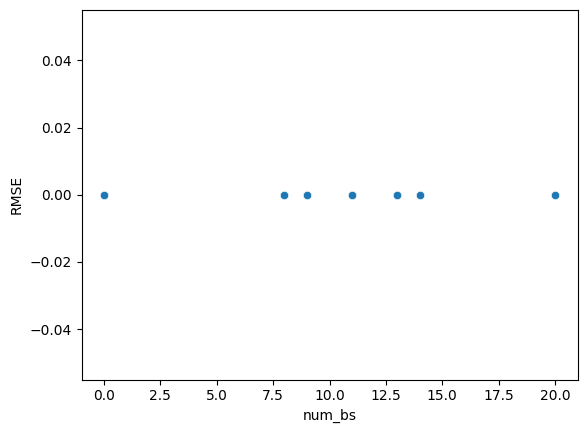

In [15]:
sns.scatterplot(infom, x='num_bs', y='RMSE')